In [1]:
# importing necessary libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os

# Training the model on shuffled training data and predicting the trash bucket

Data Pre-processing

In [7]:
# extracting and preprocessing data
filenames = os.listdir('dogvscat_traindata/train')
labels = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        labels.append(str(1))
    else:
        labels.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

print(df['label'].value_counts())

0    12500
1    12500
Name: label, dtype: int64


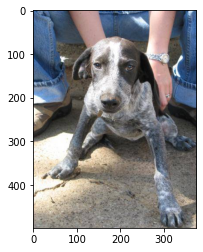

dog.2509.jpg


In [9]:
#visualizing a random data
sample = random.choice(filenames)
image = load_img("dogvscat_traindata/train/"+sample)
plt.imshow(image)
plt.show()
print(sample)

In [10]:
# splitting the training data into training and validation ( 20% of total data i.e 5000 examples)

train_data, val_data = train_test_split(df, test_size=0.2, random_state = 42)
train_data = train_data.reset_index(drop=True)   # 20000 examples
val_data = val_data.reset_index(drop=True)       # 5000 examples

print(train_data['label'].value_counts())
print(val_data['label'].value_counts())

1    10015
0     9985
Name: label, dtype: int64
0    2515
1    2485
Name: label, dtype: int64


In [11]:
# generating and augmentating training and validation data through ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    "dogvscat_traindata/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    batch_size=20
)

val_data_gen = ImageDataGenerator(rescale=1./255)

val_generator = val_data_gen.flow_from_dataframe(val_data, 
    "dogvscat_traindata/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    batch_size=20
)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Model Generation

In [6]:
# defining the model

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, input_shape = (128,128,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation ='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation ='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9

Training the dogvscat model with (train_data, val_data)

In [7]:
hist_model = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=6, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/6
1000/1000 [==============================] - 407s 406ms/step - loss: 0.6950 - binary_accuracy: 0.5132 - val_loss: 0.6767 - val_binary_accuracy: 0.6018
Epoch 2/6
1000/1000 [==============================] - 400s 400ms/step - loss: 0.6669 - binary_accuracy: 0.5968 - val_loss: 0.6186 - val_binary_accuracy: 0.6692
Epoch 3/6
1000/1000 [==============================] - 398s 398ms/step - loss: 0.6157 - binary_accuracy: 0.6576 - val_loss: 0.5678 - val_binary_accuracy: 0.7000
Epoch 4/6
1000/1000 [==============================] - 402s 402ms/step - loss: 0.5817 - binary_accuracy: 0.6968 - val_loss: 0.5140 - val_binary_accuracy: 0.7476
Epoch 5/6
1000/1000 [==============================] - 402s 401ms/step - loss: 0.5564 - binary_accuracy: 0.7127 - val_loss: 0.5132 - val_binary_accuracy: 0.7548
Epoch 6/6
1000/1000 [==============================] - 400s 400ms/step - loss: 0.5441 - binary_accuracy: 0.7201 - val_loss: 0.5085 - val_binary_accuracy: 0.7548


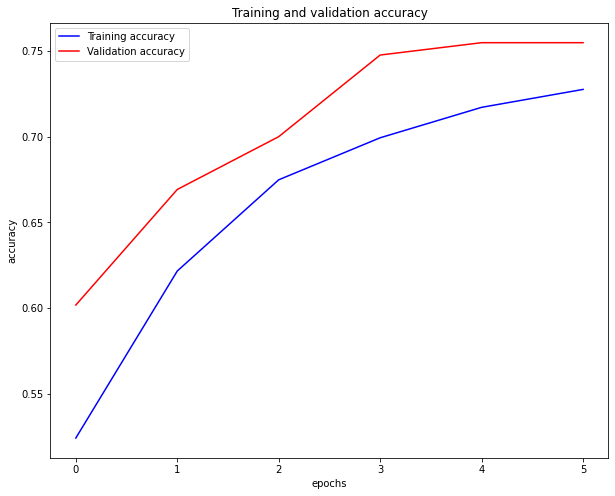

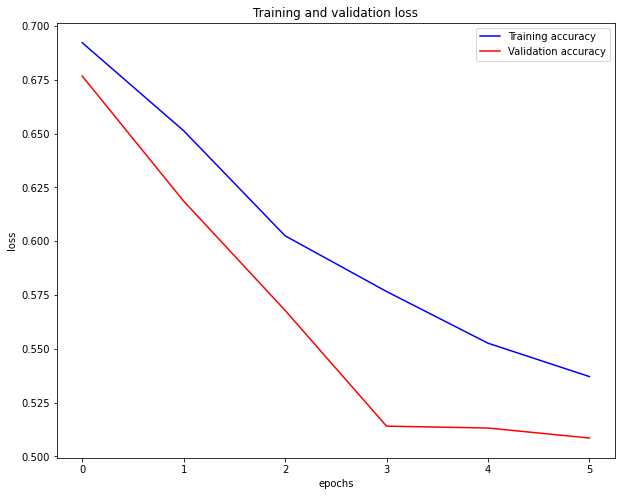

In [8]:
# code to show the training-vs-validation accuracy vs loss for animal model.

accuracy = hist_model.history['binary_accuracy']
val_accuracy = hist_model.history['val_binary_accuracy']
loss = hist_model.history['loss']
val_loss = hist_model.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,8)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [3]:
# model.save('dogvscat/dogvscat.model')
model = load_model('dogvscat/dogvscat.model')
print("Info:: {'Cat' = 0, 'Dog'= 1}")

Info:: {'Cat' = 0, 'Dog'= 1}


Testing the trained model

In [15]:
# code to test DogVsCat classfication model on testing dataset

# creating test generator to test the model
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'dogvscat/test_data/test',
    target_size=(128, 128),
    class_mode=None,
    shuffle=False,
    batch_size=1,
)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
# test_generator.reset()

Found 500 images belonging to 2 classes.


In [15]:
#predicting output label for test dataset
pred = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

# converting the predicted output data and getting desired ouput
animal_pred = [ (1 if y[0] > 0.5 else 0) for y in pred]
animal_desired = test_generator.classes
# animal_desired = test_generator.class_indices
# # labels = (train_generator.class_indices)
# # labels = dict((v,k) for k,v in labels.items())
# # predictions = [labels[k] for k in y_pred]

# saving the predicted output in a dataframe file
examplenames = test_generator.filenames
results = pd.DataFrame({"Filenames":examplenames, "Desired Output": animal_desired, "Predicted Output": animal_pred})
# results.to_csv("animal_prediction.txt", header= False, index= False, sep =' ')

# counting the number of prediction for each label
unique, counts = np.unique(animal_pred, return_counts=True)
result = dict(zip(unique, counts))
print(result)

#getting the accuracy of the model
accuracy = accuracy_score(animal_desired,animal_pred)   
print("Accuracy of dogvsCat Model: " + str((accuracy *100))+ " %.")

500/500 [==============================] - 4s 7ms/step
{0: 315, 1: 185}
Accuracy of dogvsCat Model: 76.2 %.


[[223  92]
 [ 27 158]]


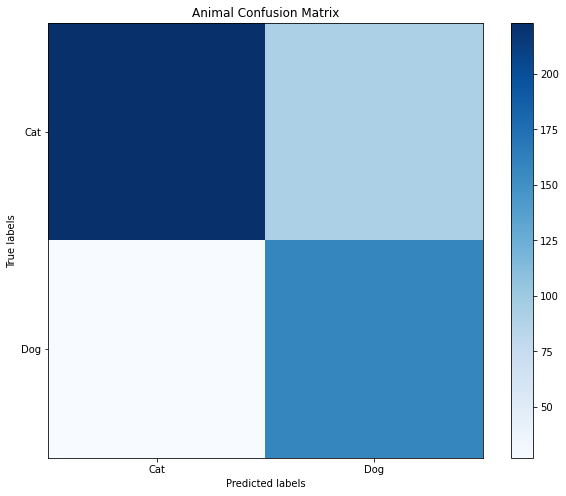

In [16]:
# Code block to print the Gender Confusion Matrix.

fig = plt.figure(figsize=(10, 8))
animal_confusion_matrix = confusion_matrix(animal_pred, animal_desired)
print(animal_confusion_matrix)

plt.imshow(animal_confusion_matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.title('Animal Confusion Matrix')
plt.colorbar()
plt.show()

In [17]:
# code to test DogVsCat classfication model with another dataset (consists images of random wild animals)

#creating dataframe for the random test
random_filenames = os.listdir('dogvscat_traindata/another_dataset/train/wild')
random_df = pd.DataFrame({ 'filename': random_filenames })
# print(random_df)

# creating test generator to test the model
random_test_datagen = ImageDataGenerator(rescale=1./255)

random_test_generator = random_test_datagen.flow_from_dataframe(
    random_df,
    'dogvscat_traindata/another_dataset/train/wild',
    x_col='filename',
    target_size=(128, 128),
    class_mode=None,
    shuffle=False,
    batch_size=1,
)

STEP_SIZE_TEST=random_test_generator.n//random_test_generator.batch_size
# random_test_generator.reset()

#predicting output label for random test dataset
pred = model.predict(random_test_generator, steps=STEP_SIZE_TEST, verbose=1)

# converting the predicted output data and getting desired ouput
random_animal_pred = [ (1 if y[0] > 0.5 else 0) for y in pred]

# saving the predicted and desired output in a dataframe
examplenames = random_test_generator.filenames
predictions = pd.DataFrame({"Filenames":examplenames, "Predicted Output": random_animal_pred})

# counting the number of prediction for each label
unique, counts = np.unique(random_animal_pred, return_counts=True)
result = dict(zip(unique, counts))
print(result)
# print(predictions)

Found 4738 validated image filenames.
4738/4738 [==============================] - 35s 7ms/step
{0: 1899, 1: 2839}


In [18]:
# creating rand_test array that contains images built from random generator numbers as pixels

rand_test = [ ]
for _ in range(5000):
    example = np.random.rand(128,128,3)
    rand_test.append(example)

rand_test = np.array(rand_test)

print(rand_test.shape)
# print(rand_test[1])
# plt.imshow(rand_test[1])
# plt.show()

(5000, 128, 128, 3)


In [19]:
# prediciting on rand_test array

rand_pred = model.predict(rand_test, steps = len(rand_test)//50, verbose=1)
random_pred = [ (1 if y[0] > 0.5 else 0) for y in rand_pred]

unique, counts = np.unique(random_pred, return_counts = True)
result = dict(zip(unique, counts))
print(result)

100/100 [==============================] - 18s 176ms/step
{0: 4880, 1: 120}


<!-- Inconclusive trash bucket, Prediction split- Cat: 55-60 & Dog: 45-40 -->
Label 0 i.e Cats seems to be the trash bucket

# Training the model on unshuffled dataset and predicting the trash bucket

Data preprocessing

In [19]:
# extracting and preprocessing data
filenames = os.listdir('dogvscat_traindata/train')

cat_train_df = pd.DataFrame( columns= ['filename', 'label'])
dog_train_df = pd.DataFrame( columns= ['filename', 'label'])

cat_val_df = pd.DataFrame( columns= ['filename', 'label'])
dog_val_df = pd.DataFrame( columns= ['filename', 'label'])

dog_train = 0
cat_train = 0

for filename in filenames:
    category = filename.split('.')[0]
    
    if category == 'dog' and dog_train < 10000:
        dog_train+=1
        dog_train_df= dog_train_df.append({'filename': filename, 'label' : '1'}, ignore_index=True)
    elif category == 'dog' and dog_train >= 10000:
        dog_val_df= dog_val_df.append({'filename': filename, 'label' : '1'}, ignore_index=True)
        
    if category == 'cat' and cat_train < 10000:
        cat_train+=1
        cat_train_df= cat_train_df.append({'filename': filename, 'label' : '0'}, ignore_index=True)
    elif category == 'cat' and cat_train >= 10000:
        cat_val_df= cat_val_df.append({'filename': filename, 'label' : '0'}, ignore_index=True)


In [20]:
# print(dog_train_df)
print(dog_train_df['label'].value_counts())

# print(dog_val_df)
print(dog_val_df['label'].value_counts())

# print(cat_train_df)
print(cat_train_df['label'].value_counts())

# print(cat_val_df)
print(cat_val_df['label'].value_counts())

1    10000
Name: label, dtype: int64
1    2500
Name: label, dtype: int64
0    10000
Name: label, dtype: int64
0    2500
Name: label, dtype: int64


# Part 1: Cat images first

In [21]:
# creating a new dataframe with cats images first and then dog images

train1_df = pd.concat([cat_train_df, dog_train_df], ignore_index = True) # 20000 examples
valid1_df = pd.concat([cat_val_df, dog_val_df], ignore_index = True) # 5000 exmaples

# print(train1_df)
print(train1_df['label'].value_counts())

# print(valid1_df)
print(valid1_df['label'].value_counts())

0    10000
1    10000
Name: label, dtype: int64
0    2500
1    2500
Name: label, dtype: int64


In [23]:
# generating and augmentating training and validation data through ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train1_generator = train_data_gen.flow_from_dataframe(
    train1_df, 
    "dogvscat_traindata/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    shuffle = False,
    batch_size=20
)

val_data_gen = ImageDataGenerator(rescale=1./255)

valid1_generator = val_data_gen.flow_from_dataframe(valid1_df, 
    "dogvscat_traindata/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    shuffle = False,                                           
    batch_size=20
)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Model Generation

In [227]:
# defining and compling the model

catfirst_model = Sequential()

catfirst_model.add(Conv2D(filters=32, kernel_size=3, input_shape = (128,128,3), padding= 'same', activation = 'relu'))
catfirst_model.add(MaxPooling2D(pool_size= (2,2)))
catfirst_model.add(Dropout(0.25))

catfirst_model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
catfirst_model.add(MaxPooling2D(pool_size= (2,2)))
catfirst_model.add(Dropout(0.25))

catfirst_model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
catfirst_model.add(MaxPooling2D(pool_size= (2,2)))
catfirst_model.add(Dropout(0.25))

catfirst_model.add(Flatten())
catfirst_model.add(Dense(64, activation ='relu'))
catfirst_model.add(Dropout(0.25))

catfirst_model.add(Dense(128, activation ='relu'))
catfirst_model.add(Dropout(0.25))

catfirst_model.add(Dense(64, activation ='relu'))
catfirst_model.add(Dropout(0.25))

catfirst_model.add(Dense(1, activation ='sigmoid'))

catfirst_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

catfirst_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)       

Training the dogvscat model with (train1_df, valid1_df) which contain cats images first

In [173]:
hist1_model = catfirst_model.fit(train1_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=6, verbose=1, validation_data=valid1_generator, validation_steps=STEP_SIZE_VALID, shuffle = False)

Epoch 1/6
1000/1000 [==============================] - 380s 379ms/step - loss: 0.2337 - binary_accuracy: 0.9942 - val_loss: 569.2219 - val_binary_accuracy: 0.5000
Epoch 2/6
1000/1000 [==============================] - 377s 377ms/step - loss: 25.6298 - binary_accuracy: 0.8678 - val_loss: 12.6720 - val_binary_accuracy: 0.5000
Epoch 3/6
1000/1000 [==============================] - 375s 375ms/step - loss: 1.0364 - binary_accuracy: 0.8505 - val_loss: 29.2379 - val_binary_accuracy: 0.5000
Epoch 4/6
1000/1000 [==============================] - 3617s 4s/step - loss: 1.5358 - binary_accuracy: 0.9026 - val_loss: 35.9968 - val_binary_accuracy: 0.5000
Epoch 5/6
1000/1000 [==============================] - 377s 376ms/step - loss: 2.0625 - binary_accuracy: 0.9172 - val_loss: 3.6855 - val_binary_accuracy: 0.5000
Epoch 6/6
1000/1000 [==============================] - 377s 377ms/step - loss: 0.8453 - binary_accuracy: 0.7737 - val_loss: 2.5662 - val_binary_accuracy: 0.5000


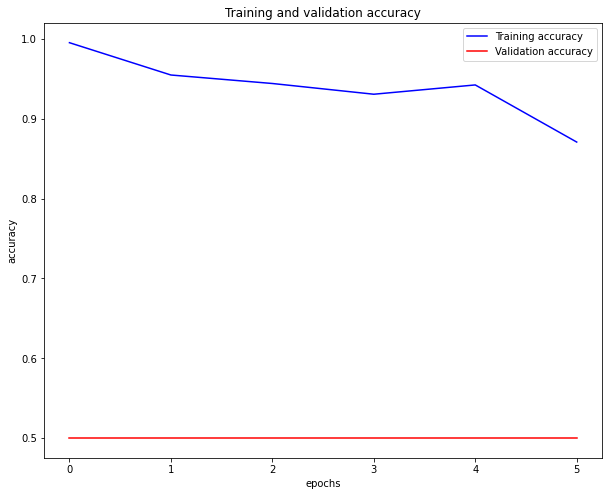

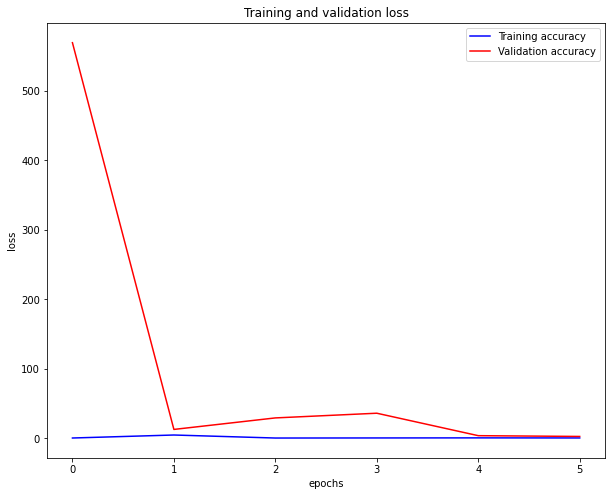

In [174]:
# code to show the training and validation output for animal model.

accuracy = hist1_model.history['binary_accuracy']
val_accuracy = hist1_model.history['val_binary_accuracy']
loss = hist1_model.history['loss']
val_loss = hist1_model.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,8)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [24]:
# catfirst_model.save('dogvscat/catfirst_dogvscat.model')
catfirst_model = load_model('dogvscat/catfirst_dogvscat.model')
print("Info:: {'Cat' = 0, 'Dog'= 1}")

Info:: {'Cat' = 0, 'Dog'= 1}


Testing the trained model

In [25]:
# code to test DogVsCat classfication model on testing dataset

# creating test generator to test the model
test_datagen = ImageDataGenerator(rescale=1./255)

test1_generator = test_datagen.flow_from_directory(
    'dogvscat/test_data/test/',
    target_size=(128, 128),
    class_mode=None,
    shuffle=False,
    batch_size=1,
)

STEP_SIZE_TEST=test1_generator.n//test1_generator.batch_size


Found 500 images belonging to 2 classes.


In [310]:
#predicting output label for test1 dataset
pred1 = catfirst_model.predict(test1_generator, steps=STEP_SIZE_TEST, verbose=1)

# converting the predicted output data and getting desired ouput
animal1_pred = [ (1 if y[0] > 0.5 else 0) for y in pred1]
animal1_desired = test1_generator.classes

# saving the predicted output in a text file
examplenames = test1_generator.filenames
results1 = pd.DataFrame({"Filenames":examplenames, "Desired Output": animal1_desired, "Predicted Output": animal1_pred})

accuracy = accuracy_score(animal1_desired,animal1_pred)   
print("Accuracy of dogvscat Model: " + str((accuracy *100))+ " %.")

500/500 [==============================] - 4s 8ms/step
Accuracy of dogvscat Model: 50.0 %.


[[  0   0]
 [250 250]]


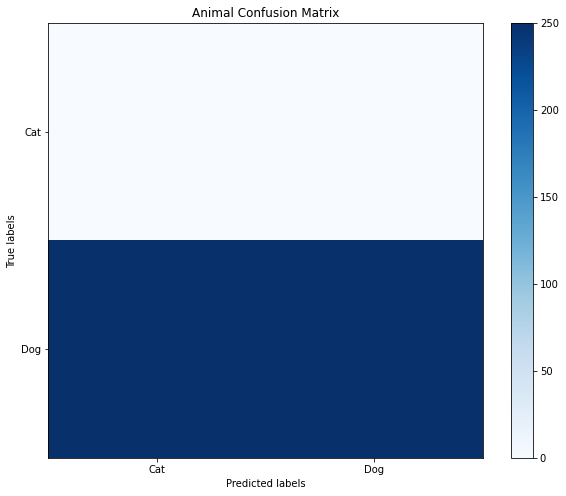

In [311]:
# Code block to print the Gender Confusion Matrix.

fig = plt.figure(figsize=(10, 8))
animal1_confusion_matrix = confusion_matrix(animal1_pred, animal1_desired)
print(animal1_confusion_matrix)

plt.imshow(animal1_confusion_matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.title('Animal Confusion Matrix')
plt.colorbar()
plt.show()

In [312]:
# creating rand_test array that contains images built from random generator numbers as pixels
rand1_test = [ ]

for _ in range(5000):
    example = np.random.rand(128,128,3)
    rand1_test.append(example)

rand1_test = np.array(rand1_test)

print(rand1_test.shape)
# plt.imshow(rand_test[1])
# plt.show()

(5000, 128, 128, 3)


In [313]:
# prediciting on rand_test array

rand1_pred = catfirst_model.predict(rand1_test, steps = len(rand1_test)//50, verbose=1)

random1_pred = [ (1 if y[0] > 0.5 else 0) for y in rand1_pred]

unique, counts = np.unique(random1_pred, return_counts = True)
result = dict(zip(unique, counts))
print(result)

100/100 [==============================] - 20s 197ms/step
{1: 5000}


Since the model was trained with dogs at the end it will predict any image as a dog

# Part 2: Dog images first

In [27]:
train2_df = pd.concat([dog_train_df, cat_train_df], ignore_index = True) # 20000 examples
valid2_df = pd.concat([dog_val_df, cat_val_df], ignore_index = True) # 5000 exmaples

# print(train2_df)
print(train2_df['label'].value_counts())

# print(valid2_df)
print(valid2_df['label'].value_counts())

0    10000
1    10000
Name: label, dtype: int64
0    2500
1    2500
Name: label, dtype: int64


In [28]:
# generating and augmentating training and validation data through ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train2_generator = train_data_gen.flow_from_dataframe(
    train2_df, 
    "dogvscat_traindata/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    shuffle = False,
    batch_size=20
)

val_data_gen = ImageDataGenerator(rescale=1./255)

valid2_generator = val_data_gen.flow_from_dataframe(valid2_df, 
    "dogvscat_traindata/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    shuffle = False,                                           
    batch_size=20
)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

# print(train2_generator.filenames)
# print(valid2_generator.filenames)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Model Generation

In [281]:
# defining and compling the model

dogfirst_model = Sequential()

dogfirst_model.add(Conv2D(filters=32, kernel_size=3, input_shape = (128,128,3), padding= 'same', activation = 'relu'))
dogfirst_model.add(MaxPooling2D(pool_size= (2,2)))
dogfirst_model.add(Dropout(0.25))

dogfirst_model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
dogfirst_model.add(MaxPooling2D(pool_size= (2,2)))
dogfirst_model.add(Dropout(0.25))

dogfirst_model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
dogfirst_model.add(MaxPooling2D(pool_size= (2,2)))
dogfirst_model.add(Dropout(0.25))

dogfirst_model.add(Flatten())
dogfirst_model.add(Dense(64, activation ='relu'))
dogfirst_model.add(Dropout(0.25))

dogfirst_model.add(Dense(128, activation ='relu'))
dogfirst_model.add(Dropout(0.25))

dogfirst_model.add(Dense(64, activation ='relu'))
dogfirst_model.add(Dropout(0.25))

dogfirst_model.add(Dense(1, activation ='sigmoid'))

dogfirst_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

dogfirst_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)       

Training the dogvscat model with (train2_df, valid2_df) with dog images first

In [282]:
hist2_model = dogfirst_model.fit(train2_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=6, verbose=1, validation_data=valid2_generator, validation_steps=STEP_SIZE_VALID, shuffle = False)

Epoch 1/6
1000/1000 [==============================] - 440s 439ms/step - loss: 0.1990 - binary_accuracy: 0.9909 - val_loss: 70.5050 - val_binary_accuracy: 0.5000
Epoch 2/6
1000/1000 [==============================] - 415s 415ms/step - loss: 4.0073 - binary_accuracy: 0.8882 - val_loss: 13.3986 - val_binary_accuracy: 0.5000
Epoch 3/6
1000/1000 [==============================] - 397s 397ms/step - loss: 0.9345 - binary_accuracy: 0.9112 - val_loss: 4.4361 - val_binary_accuracy: 0.5000
Epoch 4/6
1000/1000 [==============================] - 392s 392ms/step - loss: 0.7205 - binary_accuracy: 0.8277 - val_loss: 3.6722 - val_binary_accuracy: 0.5000
Epoch 5/6
1000/1000 [==============================] - 388s 388ms/step - loss: 0.9375 - binary_accuracy: 0.7126 - val_loss: 2.8636 - val_binary_accuracy: 0.5000
Epoch 6/6
1000/1000 [==============================] - 389s 389ms/step - loss: 0.8004 - binary_accuracy: 0.7355 - val_loss: 2.2515 - val_binary_accuracy: 0.5000


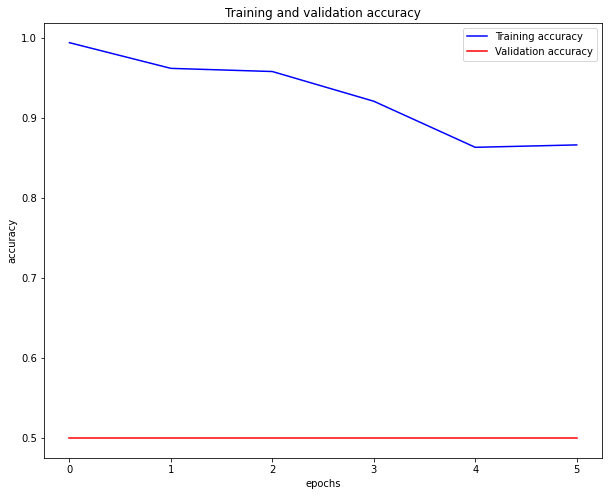

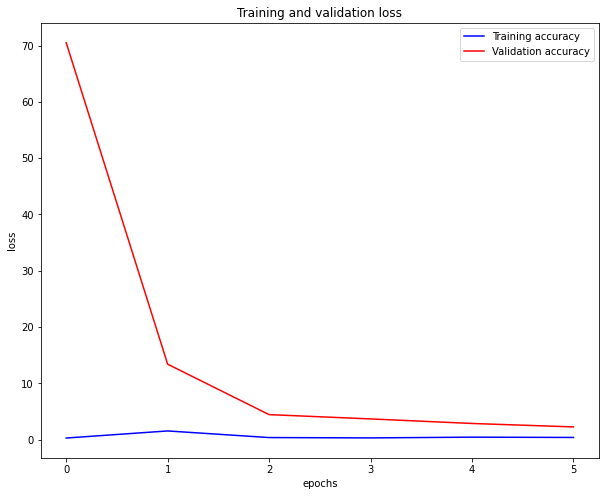

In [283]:
# code to show the training and validation output for animal model.

accuracy = hist2_model.history['binary_accuracy']
val_accuracy = hist2_model.history['val_binary_accuracy']
loss = hist2_model.history['loss']
val_loss = hist2_model.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,8)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [29]:
# dogfirst_model.save('dogvscat/dogfirst_dogvscat.model')
dogfirst_model = load_model('dogvscat/dogfirst_dogvscat.model')
print("Info:: {'Cat' = 0, 'Dog'= 1}")

Info:: {'Cat' = 0, 'Dog'= 1}


Testing the trained model

In [30]:
# code to test DogVsCat classfication model on testing dataset

# creating test generator to test the model
test_datagen = ImageDataGenerator(rescale=1./255)

test2_generator = test_datagen.flow_from_directory(
    'dogvscat/test_data/test/',
    target_size=(128, 128),
    class_mode=None,
    shuffle=False,
    batch_size=1,
)

STEP_SIZE_TEST=test2_generator.n//test2_generator.batch_size


Found 500 images belonging to 2 classes.


In [289]:
#predicting output label for test1 dataset
pred2 = dogfirst_model.predict(test2_generator, steps=STEP_SIZE_TEST, verbose=1)

# converting the predicted output data and getting desired ouput
animal2_pred = [ (1 if y[0] > 0.5 else 0) for y in pred2]
animal2_desired = test2_generator.classes

# saving the predicted output in a text file
examplenames = test2_generator.filenames
results2 = pd.DataFrame({"Filenames":examplenames, "Desired Output": animal2_desired, "Predicted Output": animal2_pred})

accuracy = accuracy_score(animal2_desired,animal2_pred)   
print("Accuracy of dogvscat Model: " + str((accuracy *100))+ " %.")

500/500 [==============================] - 4s 7ms/step
Accuracy of dogvscat Model: 50.0 %.


[[250 250]
 [  0   0]]


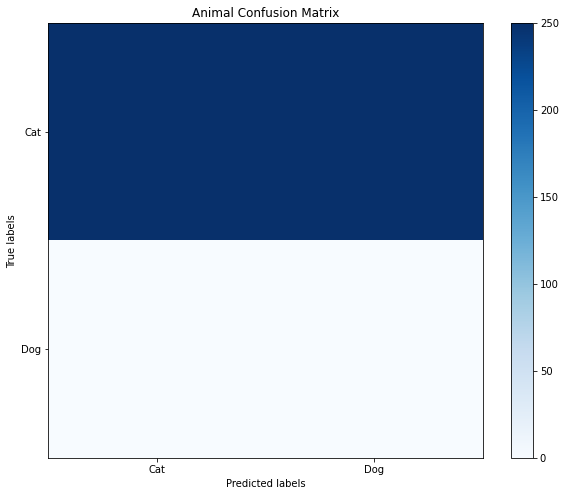

In [295]:
# Code block to print the Gender Confusion Matrix.

fig = plt.figure(figsize=(10, 8))
animal2_confusion_matrix = confusion_matrix(animal2_pred, animal2_desired)
print(animal2_confusion_matrix)

plt.imshow(animal2_confusion_matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.title('Animal Confusion Matrix')
plt.colorbar()
plt.show()

In [296]:
# creating rand_test array that contains images built from random generator numbers as pixels
rand2_test = [ ]

for _ in range(5000):
    example = np.random.rand(128,128,3)
    rand2_test.append(example)

rand2_test = np.array(rand2_test)

print(rand2_test.shape)
# plt.imshow(rand_test[1])
# plt.show()

(5000, 128, 128, 3)


In [297]:
# prediciting on rand_test array

rand2_pred = dogfirst_model.predict(rand2_test, steps = len(rand2_test)//50, verbose=1)

random2_pred = [ (1 if y[0] > 0.5 else 0) for y in rand2_pred]

unique, counts = np.unique(random2_pred, return_counts = True)
result = dict(zip(unique, counts))
print(result)

100/100 [==============================] - 18s 182ms/step
{0: 5000}


Since the model was trained with cats at the end it will predict any image as a cat

# Not shuffling the data in binary case doesn't help with training. Hence, no conclusive inference about trash bucket can be made.